In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import os
import matplotlib.pyplot as plt
from configs.RecursiveVPSDE.Markovian_40DLorenz.recursive_Markovian_PostMeanScore_40DLorenz_Chaos_T256_H05_tl_110data_StbleTgt_FULLDATA import get_config

In [2]:
config = get_config()
num_paths = 1024 if config.feat_thresh == 1. else 10240
assert num_paths == 10240
root_dir = "/Users/marcos/Library/CloudStorage/OneDrive-ImperialCollegeLondon/StatML_CDT/Year2/DiffusionModels/"

In [3]:
import pandas as pd
def get_drift_files(config, root_dir ):
    ts_type = f"{config.ndims}DLnz"
    include = (f"_{num_paths}NPaths_{config.t0}t0_{config.deltaT:.3e}dT_").replace(".", "")
    root_nadaraya_dir = root_dir + f"ExperimentResults/Nadaraya/40DLnzChaos/"
    true_files = []
    local_files = []
    mses = []
    for file in os.listdir(root_nadaraya_dir):
        if "IIDNadaraya" in file and ts_type in file and include in file and ((f"{config.forcing_const}FConst").replace(".","") in file):
            if "true" in file:
                true_files.append(root_nadaraya_dir+file)
            elif "global" in file:
                local_files.append(root_nadaraya_dir+file)
            elif "bwidx" in file and "MSEs" not in file:
                mses_full = pd.read_parquet(root_nadaraya_dir+file)
                mses.append(mses_full)
    mses = pd.concat(mses).sort_values("bw", axis=0).dropna()
    assert len(true_files)>0, "No true files found"
    assert len(local_files)>0, "No local files found"
    #assert (len(true_files) == len(local_files))
    def extract_bw_number(s):
        match = s.split("/")[-1].split("_")[3][:-2]
        return float("0." + match)
    true_files = sorted(true_files, key=extract_bw_number)
    local_files = sorted(local_files, key=extract_bw_number)
    bws = [extract_bw_number(f) for f in true_files]
    return true_files, local_files, bws, mses

In [4]:
config = get_config()
true_files, local_files, bws, mses = get_drift_files(config=config, root_dir=root_dir)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


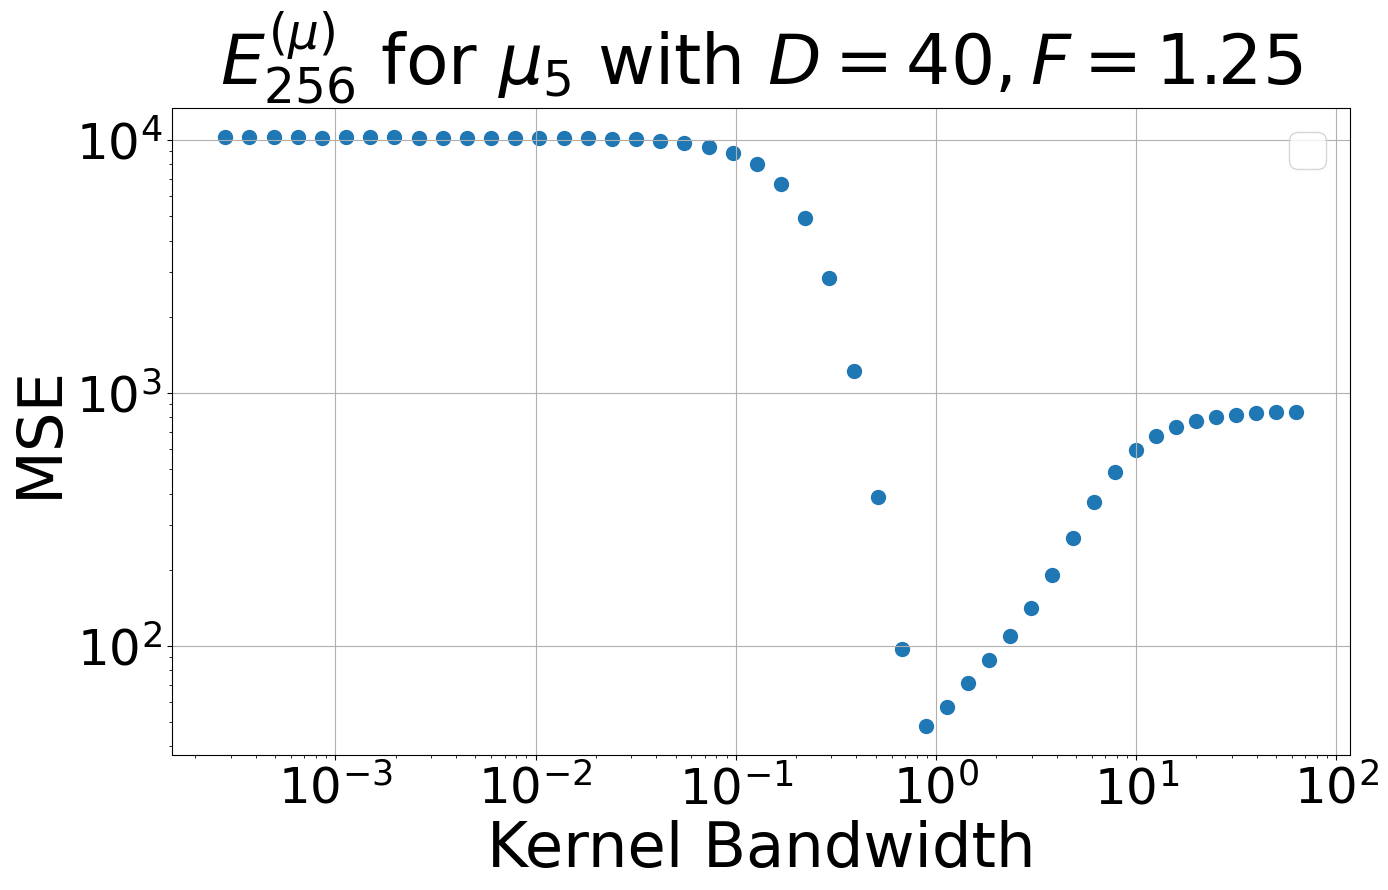

48.35961


In [8]:
fig, ax = plt.subplots(figsize=(14,9))
mses.plot(kind="scatter", x="bw", y="mse", ax=ax, s=100)
ax.set_xscale("log")
ax.set_yscale("log")
ax.tick_params(labelsize=36)
ax.set_ylabel("MSE", fontsize=45)
ax.set_xlabel("Kernel Bandwidth", fontsize=45)
plt.legend(fontsize=34)
ax.set_title(f"$E^{{(\\mu)}}_{{256}}$ for $\\mu_5$ with $D={config.ndims}, F=1.25$",fontsize=50)
plt.grid(True)
plt.tight_layout()
#plt.savefig(f"/Users/marcos/Library/CloudStorage/OneDrive-ImperialCollegeLondon/StatML_CDT/Year2/DiffusionModels/DiffusionModelPresentationImages/FullData/{config.ndims}DLnzFullDataBandwidth.png")
plt.show()
plt.close()
print(mses.iloc[np.argmin(mses.mse),1])

In [6]:
curr_rmse = np.inf
toSave = False
i = 0
for file in zip(*[true_files, local_files, bws]):
    bw = file[-1]
    all_true_states = np.load(file[0])
    all_local_states = np.load(file[1])
    if all_local_states.shape[0] != 2: continue
    if (len(all_true_states.shape) == len(all_local_states.shape) == 4):
        time_steps = np.linspace(config.t0,config.deltaT*all_true_states.shape[2],all_true_states.shape[2])
        all_global_errors = np.sum(np.power(all_true_states- all_local_states,2), axis=-1)
        all_global_errors=all_global_errors.reshape(-1, all_global_errors.shape[-1])            # (K, N, T)
        total_local_errors = np.sqrt(np.nanmean(all_global_errors, axis=(0)))/np.sqrt(time_steps)
        all_paths_err = np.sqrt(all_global_errors)/np.sqrt(time_steps)
        total_local_errors[total_local_errors==np.inf] = 0.
        all_paths_err[all_paths_err==np.inf] = 0.
        total_local_errors_minq, total_local_errors_maxq  = np.quantile(all_paths_err, q=[0.005, 0.995], axis=0) # (T,)
        print(total_local_errors[-1], bw, curr_rmse)
        i += 1
        if total_local_errors[-1]  < curr_rmse:
            curr_rmse = total_local_errors[-1]
            fig, ax = plt.subplots(figsize=(14,9))
            plt.grid(True)
            ax.scatter(time_steps, total_local_errors)
            plt.fill_between(time_steps,y1=total_local_errors_minq, y2=total_local_errors_maxq, color="blue", alpha=0.4)
            ax.set_title(rf"Pathwise RMSE for Nadaraya Estimator for $\mu_5$",fontsize=40)
            ax.set_ylabel("MSE", fontsize=38)
            ax.set_xlabel("Time Axis", fontsize=38)
            ax.tick_params(labelsize=38)
            plt.tight_layout()
            if toSave:
                plt.savefig((root_dir + f"DiffusionModelPresentationImages/IIDNadaraya/40DLnzChaos/IIDNadaraya_{config.ndims}DLnz_DriftTrack_{round(bw, 6)}bw_{config.forcing_const}FConst_{config.forcing_const}FConst_{round(total_local_errors_minq[-1], 8)}_MinIQR_{round(total_local_errors[-1], 8)}MeanIQR_{round(total_local_errors_maxq[-1], 8)}_MaxIQR").replace(".", "")+".png")
            plt.show()
            plt.close()
            print(f"Final time cumulative MSE local-time error {total_local_errors[-1]} with IQR ({total_local_errors_minq[-1], total_local_errors_maxq[-1]})at bw {bw} for {config.forcing_const}FConst\n")

In [7]:
from utils.resource_logger import wallclock_and_system_metrics
data = wallclock_and_system_metrics(config.nadaraya_resource_logging_path, inclusive=False)
data

FileNotFoundError: [Errno 2] No such file or directory: '/Users/marcos/GitHubRepos/FractionalBrownianMotion/src/generative_modelling/resource_logging/trained_rec_PM_ST_0100FTh_MLP_2LFac_NSTgtNFMReg_40DLnz_125e+00FConst_VPSDE_T256_Ndiff10000_Tdiff1000e+00_DiffEmbSz64_ResLay10_ResChan8_DiffHdnSz64_TrueHybd_TrueWghts_t00_dT3906e-03_MLP_H4_CUp20_tl110.json.json'